In [55]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from radioReduction import *
from astropy.stats import LombScargle
from scipy import optimize
from scipy.interpolate import make_interp_spline, BSpline

ax[0].

In [134]:
dt = pd.read_table('2m1314_data_table.txt',sep=' ')
list(dt)
print(dt['MJD'])

0     57425.506605
1     57437.457583
2     57452.489273
3     57465.226390
4     57481.170270
5     57493.139864
6     57508.351630
7     57522.261785
8     57536.190674
9     57551.056628
10    57565.150769
11    57577.096124
12    57606.036814
13    57620.018996
14    57634.996105
15    57648.965253
16    57682.721450
17    57704.824840
18    57771.525539
19    57832.294937
Name: MJD, dtype: float64


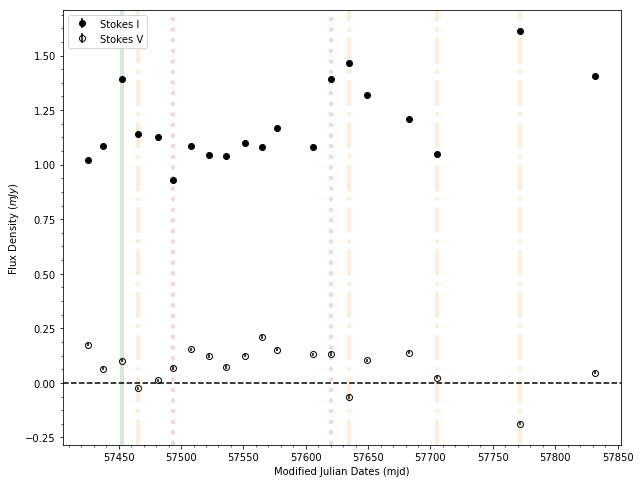

In [227]:
plt.figure(figsize=(10,8))
plt.errorbar(dt['MJD'],stI,yerr=stErr,fmt='o',color='black',linestyle='None',label='Stokes I')
plt.errorbar(time,stV,yerr=stErr,color='k',marker='o',markerfacecolor='none',linestyle='None',label='Stokes V')

# Pointing out epochs with flares/step-behavior
plt.axvline(x=57452.489273,color='darkgreen',linewidth=4,alpha=0.15)
plt.axvline(x=57620.018996,color='darkred',linestyle=':',linewidth=4,alpha=0.15)
plt.axvline(x=57493.139864,color='darkred',linestyle=':',linewidth=4,alpha=0.15)
plt.axvline(x=57465.226390,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
plt.axvline(x=57634.996105,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
plt.axvline(x=57704.824840,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
plt.axvline(x=57771.525539,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)

# Making it look pretty
plt.axhline(y=0,color='k',linestyle='dashed')
plt.minorticks_on()
plt.ylabel('Flux Density ($mJy$)')
plt.xlabel('Modified Julian Dates (mjd)')
plt.legend(loc=2)

plt.savefig('plots/1314LongTerm.png')
plt.show()

In [58]:
freq, power = LombScargle(longTerm['mjd'],longTerm['re'],longTerm['ure'],nterms=3).autopower()
plt.plot(freq,power)
plt.show()
best_freq = freq[np.argmax(power)]
x_fit = np.linspace(np.min(longTerm['mjd']),np.max(longTerm['mjd']))
y_fit = LombScargle(longTerm['mjd'],longTerm['re'],longTerm['ure'],nterms=3).model(x_fit,best_freq)

longTerm.plot.scatter('mjd','re',yerr='ure',color='black')
plt.plot(x_fit,y_fit,color='red')
plt.show()

print(1/best_freq)

NameError: name 'longTerm' is not defined

## Looking at SED and Stokes V

In [192]:
# SED
low = pd.DataFrame(data={'mjd':dt['MJD'],'re':dt['5 GHz Flux ($\\m Jy$)'],'ure':dt['5 GHz err ($\\m Jy$)']})
high = pd.DataFrame(data={'mjd':dt['MJD'],'re':dt['7 GHz Flux ($\\m Jy$)'],'ure':dt['7 GHz err ($\\m Jy$)']})
ratio = high['re']/low['re']
ratioErr = np.abs(ratio)*np.sqrt((high['ure']/high['re'])**2+(low['ure']/low['re'])**2)

# Stokes V
ll = glob.glob('1314/*-LL.dat')
rr = glob.glob('1314/*-RR.dat')

re = []
ure = []
mjd = []

for i in ll:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
ll = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
ll = ll.sort_values('mjd')
ll = ll.reset_index(drop=True)

re = []
ure = []
mjd = []
for i in rr:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
    
rr = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
rr = rr.sort_values('mjd')
rr = rr.reset_index(drop=True)

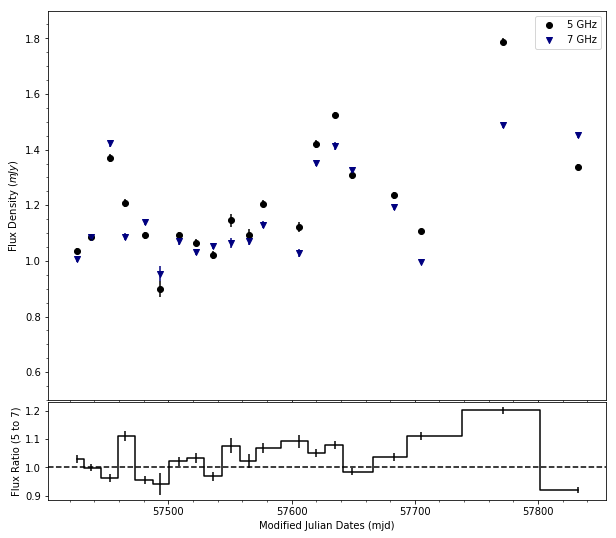

In [107]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(10,9),gridspec_kw = {'hspace':.01,'height_ratios':[4,1]},sharex=True)
ax[0].scatter(low['mjd'],low['re'],color='k',marker='o',label='5 GHz')
ax[0].errorbar(low['mjd'],low['re'],yerr=low['ure'],color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(high['mjd'],high['re'],color='navy',marker='v',label='7 GHz')
ax[0].errorbar(high['mjd'],high['re'],yerr=high['ure'],color='navy',linestyle='None',label='_nolegend_')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].set_ylim(0.5,1.9)
ax[0].minorticks_on()

ax[1].plot(low['mjd'],ratio,color='black',drawstyle='steps-mid')
ax[1].axhline(y=1,color='k',linestyle='dashed')
ax[1].errorbar(low['mjd'],ratio,color='black',yerr=ratioErr,linestyle='none',label='_nolegend_')
ax[1].set_ylabel('Flux Ratio (5 to 7)')
plt.xlabel('Modified Julian Dates (mjd)')
plt.savefig('plots/SED_Ratio_1314.png')
plt.show()

In [285]:
# Calculating spectral index alpha
alpha = np.log10(ratio)/np.log10(7/5)

# Calculating Error on alpha
errLogR = ratioErr/ratio
alphaErr = np.abs(1/np.log10(7/5))*errLogR

# Calculating the stokes V
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['mjd']

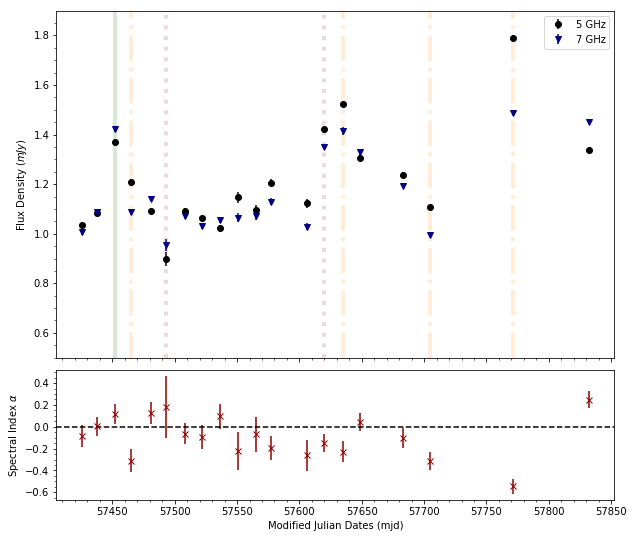

In [223]:
# PLotting SED compared to alpha values
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(10,9),gridspec_kw = {'hspace':.05,'height_ratios':[4,1.5]},sharex=True)
ax[0].errorbar(low['mjd'],low['re'],yerr=low['ure'],color='k',fmt='o',linestyle='None',label='5 GHz')
ax[0].errorbar(high['mjd'],high['re'],yerr=high['ure'],color='navy',fmt='v',linestyle='None',label='7 GHz')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].set_ylim(0.5,1.9)
# Pointing out epochs with flares/step-behavior
ax[0].axvline(x=57452.489273,color='darkgreen',linewidth=4,alpha=0.15)
ax[0].axvline(x=57620.018996,color='darkred',linestyle=':',linewidth=4,alpha=0.15)
ax[0].axvline(x=57493.139864,color='darkred',linestyle=':',linewidth=4,alpha=0.15)
ax[0].axvline(x=57465.226390,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
ax[0].axvline(x=57634.996105,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
ax[0].axvline(x=57704.824840,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
ax[0].axvline(x=57771.525539,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
ax[0].minorticks_on()

ax[1].errorbar(low['mjd'],alpha,color='darkred',yerr=alphaErr,fmt='x',linestyle='None',label='_nolegend_')
ax[1].axhline(y=0,color='k',linestyle='dashed')
ax[1].set_ylabel('Spectral Index $\\alpha$')
ax[1].minorticks_on()

plt.xlabel('Modified Julian Dates (mjd)')
plt.savefig('plots/1314_SED_Alpha.png')
plt.show()

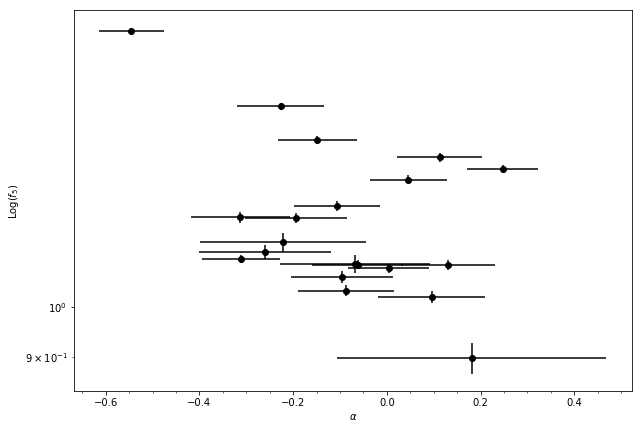

In [283]:
plt.figure(figsize=(10,7))
plt.errorbar(alpha,low['re'],yerr=low['ure'],xerr=alphaErr,linestyle='none',marker='o',color='k')
plt.yscale('log')
plt.minorticks_on()
plt.ylabel('Log($f_5$)')
plt.xlabel('$\\alpha$')
plt.show()

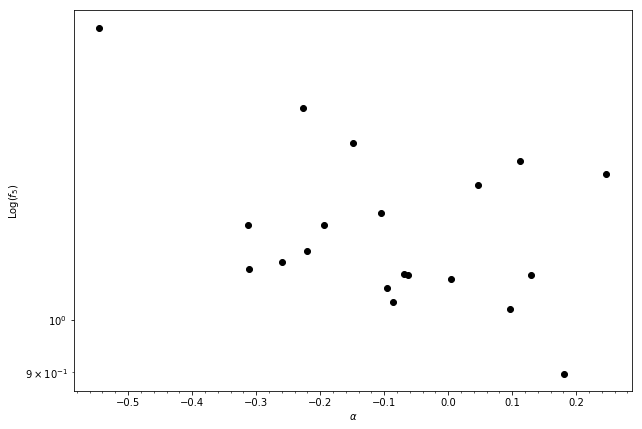

In [279]:
plt.figure(figsize=(10,7))
plt.semilogy(alpha,low['re'],linestyle='none',marker='o',color='k')
#plt.yscale('log')
plt.minorticks_on()
plt.ylabel('Log($f_5$)')
plt.xlabel('$\\alpha$')
plt.show()

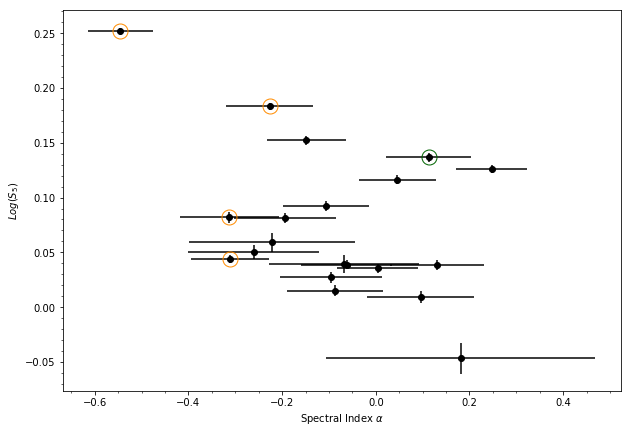

In [286]:
log5Err = 0.434*(low['ure']/low['re'])
plt.figure(figsize=(10,7))
plt.errorbar(alpha,log5,yerr=log5Err,xerr=alphaErr,linestyle='None',color='k',marker='o')

ep = [3,14,17,18]
for i in ep:
    plt.errorbar(alpha[i],log5[i],linestyle='none',color='darkorange',marker='o',markerfacecolor='None',ms=15)
plt.errorbar(alpha[2],log5[2],linestyle='none',color='darkgreen',marker='o',markerfacecolor='None',ms=15)
plt.xlabel('Spectral Index $\\alpha$')
plt.ylabel('$Log(S_5)$')
plt.minorticks_on()
plt.savefig('plots/1314_alphaLog5.png')
plt.show()

In [250]:
print(low['re'].iloc[18]/high['re'].iloc[18])

1.2013839916253783


In [253]:
stV.mean()

0.07796953220731298

In [260]:
stV.std()
std = stV.std()
mean = stV.mean()

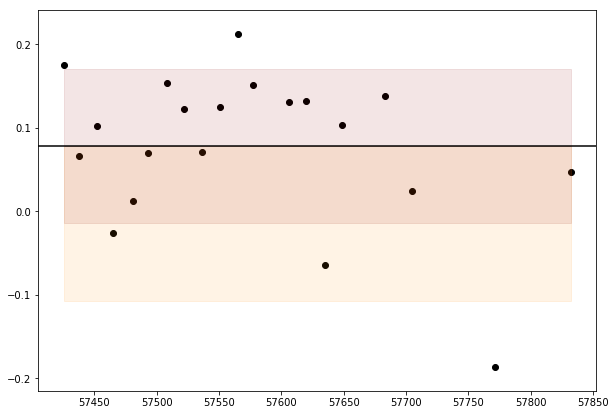

In [268]:
plt.figure(figsize=(10,7))
plt.scatter(time,stV,color='k')
plt.axhline(y=mean,color='k')
plt.fill_between(time,mean,mean-std,color='darkred',alpha=0.1)
plt.fill_between(time,mean,mean+std,color='darkred',alpha=0.1)
plt.fill_between(time,mean,mean-2*std,color='darkorange',alpha=0.1)

plt.show()